In [1]:
import numpy as np
import xarray as xr
from useful_functions import data_compiler
from useful_functions import month_genesis_locs
from useful_functions import grid_counter
from useful_functions import environmental_select_stack
from useful_functions import create_genesis_grid_labels
import os
import tropycal.tracks as tracks
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Compile Environmental Data
vars_list = os.listdir("/glade/work/acheung/TC_Genesis") # Determine Variables
vars_list.remove('.DS_Store')
vars_list.remove('CRH_ERA5')
# all_stacked_vars = []
all_vars_list = []
for vars_list_now in vars_list:
    Varcompiled, YearList,lons,lats,arr = data_compiler(vars_list_now)
    all_vars_list.append(Varcompiled)

arr = xr.DataArray(all_vars_list,coords=[("Variable",vars_list),("Year",range(1950,2021)),("Latitude",lats),("Longitude",lons),("Month",range(1,13))])

# # Time ranges for EVERYTHING desired
# year_range = np.arange(2017,2021,1)
month_range = np.arange(6,12,1)
test_years = np.arange(2005,2021,1)
train_years = np.arange(1950,2005,1)
train_years = np.setdiff1d(train_years, np.arange(1971,1979,1))
Latitude=np.arange(0,80,2)
Longitude=np.arange(260,360,2)

train_stacked,train_NaNlocs = environmental_select_stack(month_range,train_years,Latitude,Longitude,arr)
test_stacked,test_NaNlocs = environmental_select_stack(month_range,test_years,Latitude,Longitude,arr)

train_env_data = train_stacked.drop_isel(z=train_NaNlocs).transpose()
test_env_data = test_stacked.drop_isel(z=test_NaNlocs).transpose()

In [3]:
# Grab ibtracs data
basin_dataset = tracks.TrackDataset(basin='north_atlantic',source='ibtracs',include_btk=True)

--> Starting to read in ibtracs data
--> Completed reading in ibtracs data (6.65 seconds)
--> Starting to read in best track data
--> Completed reading in best track data (0.22 seconds)


In [ ]:
# Create genesis labels from ibtracs data
vmin=0
print('Training Dataset')
train_labels_predropped = create_genesis_grid_labels(month_range,train_years,vmin,basin_dataset)
print('Testing Dataset')
test_labels_predropped = create_genesis_grid_labels(month_range,test_years,vmin,basin_dataset)
train_labels = train_labels_predropped.drop_isel(z=train_NaNlocs)
test_labels = test_labels_predropped.drop_isel(z=test_NaNlocs)

Training Dataset
Testing Dataset


In [5]:
clf = RandomForestClassifier()
clf.fit(train_env_data, train_labels)
prediction = clf.predict(test_env_data)
# clf.coef_

In [6]:
np.shape(clf.predict_proba(test_env_data)[:,1])

(116640,)

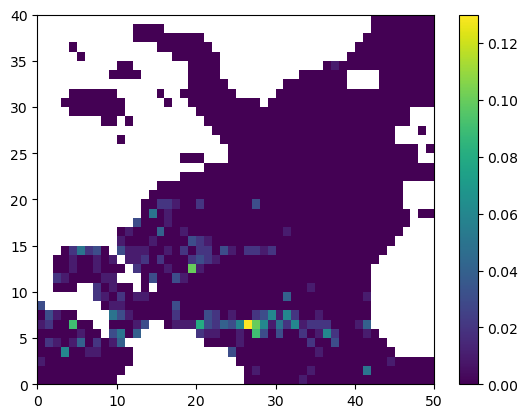

In [12]:
arrwhat = xr.DataArray(clf.predict_proba(test_env_data)[:,1],coords=test_labels.coords).unstack()
plt.pcolormesh(arrwhat.sel(Month=7,Year=2005))
plt.colorbar()

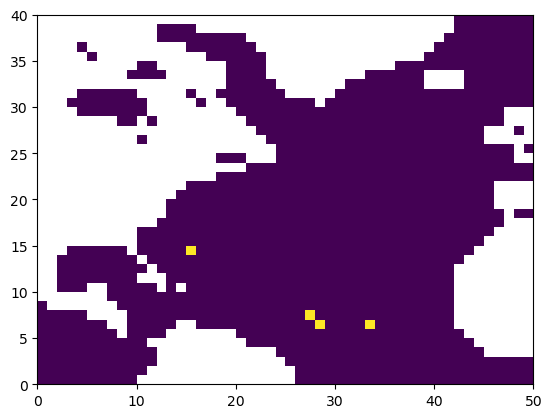

In [8]:
plt.pcolormesh(test_labels.unstack().sel(Month=8,Year=2005))


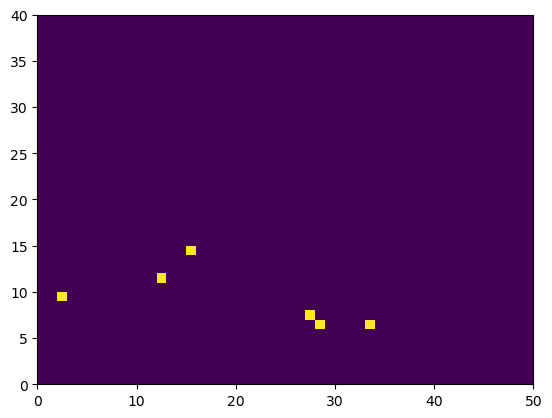

In [9]:
plt.pcolormesh(test_labels_predropped.unstack().sel(Month=8,Year=2005))


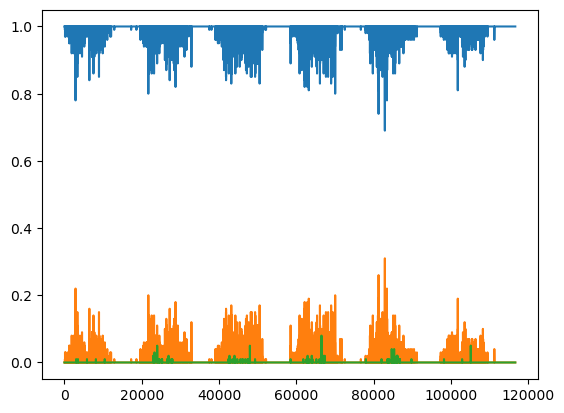

In [10]:
plt.plot(pd.DataFrame(clf.predict_proba(test_env_data)))

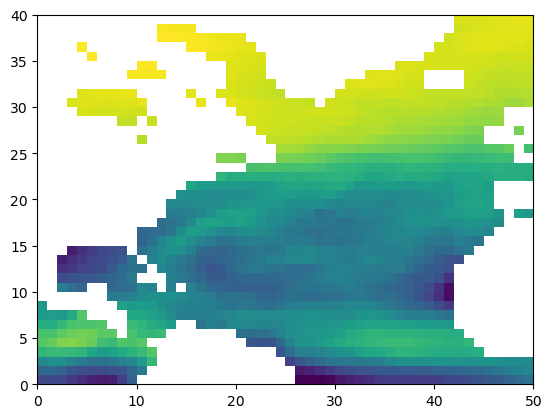

In [11]:
plt.pcolormesh(train_env_data.unstack()[3,4,:,:,0])